<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/algorithm/linalg_eig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
%reset -f

## 固有値計算

アーベル・ルフィニの定理より5次以上の代数方程式には公式が存在しない。よって5x5行列の特性方程式は直接的に解けないため、反復法を使用する。

### べき乗法

ランダム行列を作成

A=


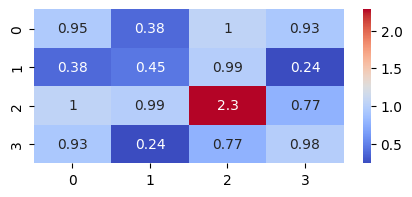

In [132]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N = 4
A = np.random.rand(N, N)
# 固有値正を保証
A = A @ A.T
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

べき乗法では対象の行列$A$のべき乗で最大固有値とその固有ベクトルを求める。

$A(A^{\infty}\vec{x})=\lambda(A^{\infty}\vec{x})$となることを利用する。

In [133]:
eps=1e-6
max_iter=100

x = (_ := np.random.rand(N)) / np.linalg.norm(_)
lambda_ = 0
for i in range(max_iter):
  # べき乗：反復毎に最大固有値の固有ベクトル成分が大きく
  v = A @ x
  # 最終的に(x,Ax)=(x,λx)=λとなるはず
  lambda_ = np.dot(x, v)
  x = v / np.linalg.norm(v)
  if np.dot(v, v) - lambda_ ** 2 < eps:
    break

print(f"{i=}")
print(f"{lambda_=:.3}")
print(f"{x=}")
print(f"{A@x-lambda_*x=}")

i=6
lambda_=3.73
x=array([0.452, 0.304, 0.743, 0.39 ])
A@x-lambda_*x=array([-4.446e-05,  3.230e-05,  4.885e-05, -6.661e-05])


### QR 分解

最も基本的な QR 分解はグラム・シュミットの直交化を利用

Q @ Q.T=


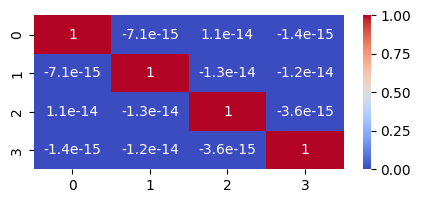

In [134]:
def gram_schmidt(vec_in_):
  vec_in = vec_in_.copy()
  vec_out = np.zeros_like(vec_in)
  # 各列を各ベクトルとみなす
  for k in range(vec_in.shape[1]):
    # 直交化の対象
    u = vec_in[:, k]
    # それまでに直交化したベクトルの成分を差し引く
    for j in range(k):
      u -= np.dot(vec_in[:, k], vec_out[:, j]) * vec_out[:, j]
    vec_out[:, k] = u / np.linalg.norm(u)
  return vec_out

Q = gram_schmidt(A)

# 直交行列になっているか確認
print("Q @ Q.T=")
sns.heatmap(Q @ Q.T, annot=True, cmap='coolwarm')
plt.show()

対象の正則行列$A$の各列を一次独立なベクトルとみなして、グラム・シュミットで直交化。

直交化したベクトルを並べたものを行列$Q$として、$A=QR$となるように行列$R$を構成。

Q=


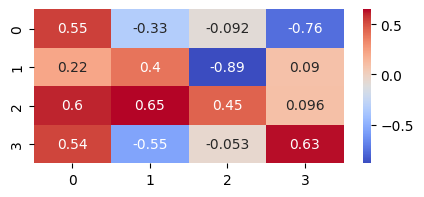

R=


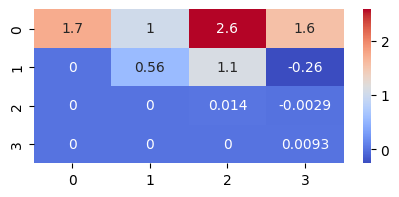

A-QR=


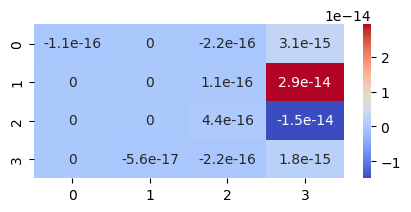

In [135]:
def QR_decomp(A_):
  A = A_.copy()
  # グラム・シュミットの直交化 -> Q を計算
  Q = gram_schmidt(A)

  R = np.zeros_like(A)
  for j in range(len(A)):
    # 上三角行列を計算 (j<=k)
    for k in range(j, len(A)):
      if j == k:
        a_k = A[:, k]
        for l in range(j):
          a_k -= np.dot(A[:, k], Q[:, l]) * Q[:, l]
        R[j, k] = np.linalg.norm(a_k)
      else:
        R[j, k] = np.dot(A[:, k], Q[:, j])
  return Q, R

Q, R = QR_decomp(A)

print("Q=")
sns.heatmap(Q, annot=True, cmap='coolwarm')
plt.show()

print("R=")
sns.heatmap(R, annot=True, cmap='coolwarm')
plt.show()

print("A-QR=")
sns.heatmap(A-Q@R, annot=True, cmap='coolwarm')
plt.show()

QR 法は QR 分解を繰り返して固有値を対角成分に持つ行列を作成。

$A_k=Q_kR_k, A_{k+1}=R_kQ_k=Q_k^{-1}AQ_k=Q_k^TAQ_k$を繰り返して、直交変換。

diag_A=


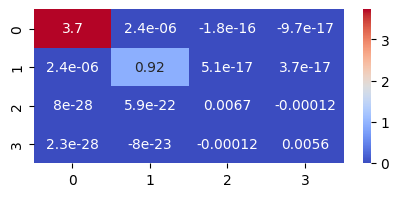

In [136]:
def QR_iteration(A_):
  A = A_.copy()
  # TODO: 終了条件を追加
  for _ in range(10):
    Q, R = QR_decomp(A)
    A = Q.T @ A @ Q
  return A

diag_A = QR_iteration(A)
print("diag_A=")
sns.heatmap(diag_A, annot=True, cmap='coolwarm')
plt.show()

In [137]:
def ordered_eigh(A):
  evalues, evectors = np.linalg.eigh(A)
  # 固有値が大きい順に並べる
  idx = evalues.argsort()[::-1]
  evalues = evalues[idx]
  evectors = evectors[:, idx]
  return evalues, evectors

evalues, evectors = ordered_eigh(A)

print(f"{evalues=}")
print(f"{evectors=}")
print(f"residuals={np.diag(diag_A)-evalues}")

evalues=array([3.729, 0.922, 0.007, 0.006])
evectors=array([[-0.452, -0.448,  0.277, -0.72 ],
       [-0.304,  0.325, -0.831, -0.332],
       [-0.743,  0.492,  0.347,  0.294],
       [-0.389, -0.672, -0.334,  0.535]])
residuals=[-2.000e-12  1.999e-12 -1.245e-05  1.245e-05]


### 逆反復法

使用する変数を整理

A=


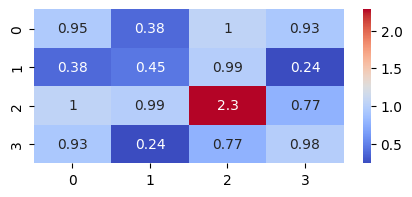

evalues=array([3.729, 0.922, 0.007, 0.006])


In [138]:
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

evalues = np.diag(diag_A)
print(f"{evalues=}")

逆反復法は近似固有値$\lambda'$に対する$((A-\lambda'E)^{-1})^\infty$を固有ベクトルとして計算する方法。

計算の過程でレイリー商による計算
\begin{equation}
R(\vec{x}^{(k)})=\frac{(\vec{x}^{(k)},(A-\lambda'E)^{-1}\vec{x}^{(k)})}{(\vec{x}^{(k)},\vec{x}^{(k)})}
=\frac{1}{\lambda-\lambda'}\equiv\mu
\end{equation}
で固有値の高精度化が図れる。

In [139]:
def inverse_iteration(A, evalues_):
  evalues = evalues_.copy()
  eps = 1e-6
  max_iter = 4
  N = A.shape[0]

  evectors = np.eye(N)
  for i in range(N):
    for _ in range(max_iter):
      # 固有ベクトル
      v = np.linalg.inv(A-evalues[i] * np.eye(N)) @ evectors[:, i]
      evectors[:, i] = v / np.linalg.norm(v)

      # 固有値を入力から高精度化
      mu = np.dot(evectors[:, i], v)
      evalues[i] += 1 / mu

      if np.linalg.norm(v) - mu**2 < eps:
        break
  return evalues, evectors

evalues, evectors = inverse_iteration(A, evalues)
print(f"{evalues=}")
print(f"{evectors=}")

evalues=array([3.729, 0.922, 0.007, 0.006])
evectors=array([[ 0.452,  0.448,  0.284,  0.718],
       [ 0.304, -0.325, -0.828,  0.338],
       [ 0.743, -0.492,  0.344, -0.296],
       [ 0.389,  0.672, -0.339, -0.532]])


計算結果を numpy による結果と比較

In [140]:
evalues_np, evectors_np = ordered_eigh(A)

# 符号を揃える
for idx in range(evectors_np.shape[1]):
  if evectors_np[0, idx] * evectors[0, idx] < 0 :
    evectors_np[:, idx] *= -1

print(f"{evalues=}")
print(f"{evalues_np=}")
print(f"{evectors=}")
print(f"{evectors_np=}")

evalues=array([3.729, 0.922, 0.007, 0.006])
evalues_np=array([3.729, 0.922, 0.007, 0.006])
evectors=array([[ 0.452,  0.448,  0.284,  0.718],
       [ 0.304, -0.325, -0.828,  0.338],
       [ 0.743, -0.492,  0.344, -0.296],
       [ 0.389,  0.672, -0.339, -0.532]])
evectors_np=array([[ 0.452,  0.448,  0.277,  0.72 ],
       [ 0.304, -0.325, -0.831,  0.332],
       [ 0.743, -0.492,  0.347, -0.294],
       [ 0.389,  0.672, -0.334, -0.535]])


evalues-evalues_np=array([2.427e-12, 8.141e-12, 2.345e-05, 3.574e-05])
residuals=


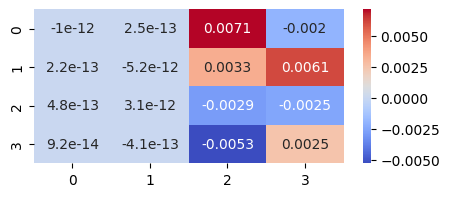

In [141]:
print(f"{evalues-evalues_np=}")
print("residuals=")
sns.heatmap(evectors-evectors_np, annot=True, cmap='coolwarm')
plt.show()

## 固有値計算の高速化

ランダム行列を再生成

A=


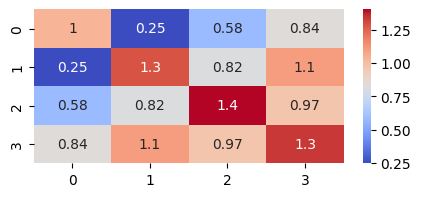

In [142]:
N = 4
A = np.random.rand(N, N)
# 固有値正を保証
A = A @ A.T
print("A=")
sns.heatmap(A, annot=True, cmap='coolwarm')
plt.show()

### ハウスホルダー変換

対角成分より2以上左の成分が0となっている行列をヘッセンベルグ行列という。
QR 分解の前処理としてハウスホルダー変換と呼ばれる直交・鏡映変換で、
対象行列をヘッセンベルグ行列へ変換する。

P=


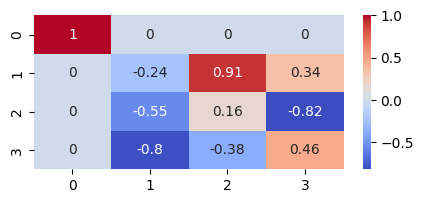

A_=


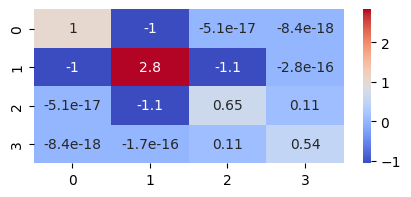

In [143]:
def householder(b):
  e = np.zeros_like(b)
  e[0] = 1
  # 桁落ち対策で異符号に
  s = -np.sign(b[0]) * np.linalg.norm(b)
  u = (_ := b - s * e) / np.linalg.norm(_)
  P = np.eye(len(b)) - 2 * np.outer(u, u)
  return P

def hessenberg(A):
  A_ = A.copy()
  P = np.eye(N)
  for k in range(N - 2):
    x = A_[k+1:, k]
    # ハウスホルダー変換
    Pk = np.eye(N)
    Pk[k+1:, k+1:] = householder(x)

    A_ = Pk @ A_ @ Pk
    P = P @ Pk

  return A_, P

A_, P = hessenberg(A)

print("P=")
sns.heatmap(P, annot=True, cmap='coolwarm')
plt.show()

print("A_=")
sns.heatmap(A_, annot=True, cmap='coolwarm')
plt.show()

evalues=array([3.636e+00, 8.879e-01, 5.363e-01, 4.081e-04])
evectors=array([[-3.541e-01,  7.889e-01,  2.124e-01,  4.551e-01],
       [-4.971e-01, -6.124e-01,  3.161e-01,  5.272e-01],
       [-5.288e-01, -8.811e-03, -8.487e-01, -7.824e-05],
       [-5.897e-01,  5.045e-02,  3.670e-01, -7.176e-01]])
A_=


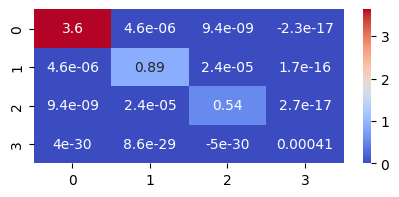

residuals=[-7.764e-12 -1.577e-09  1.585e-09 -1.366e-17]


In [144]:
evalues, evectors = np.linalg.eigh(A)
# 固有値が大きい順に並べる
idx = evalues.argsort()[::-1]
evalues = evalues[idx]
evectors = evectors[:, idx]
print(f"{evalues=}")
print(f"{evectors=}")

def QR_iteration(A):
  A_ = A.copy()
  # TODO: 終了条件を追加
  for _ in range(10):
    Q, R = QR_decomp(A_)
    A_ = Q.T @ A_ @ Q
  return A_

A_ = QR_iteration(A)
print("A_=")
sns.heatmap(A_, annot=True, cmap='coolwarm')
plt.show()
print(f"residuals={np.diag(A_)-evalues}")

### ギブンス回転

### 原点シフト

## 特異値分解

### 右特異ベクトル

行列 $A$ に対して行列 $A^TA$ を考える。
明らかに $(A^TA)^T=A^TA$ なので対称行列。
[スペクトル定理](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AB%E5%AE%9A%E7%90%86)より固有値は常に実数である。

また行列 $A$ の非負定値の条件は任意の $\vec{x}\neq\vec{0}$ に対して $\vec{x}^TA\vec{x}\geq0$。
よって任意の $A, \vec{x}\neq\vec{0}$ に対して $\vec{x}^T(A^TA)\vec{x}=||A\vec{x}||^2\geq0$。
これより固有値は常に非負である。そのため固有値の平方根も常に実数である。

これは $AA^T$ でも同様に成立。

実際に確かめるために乱数生成の行列でこれを計算。

<Axes: >

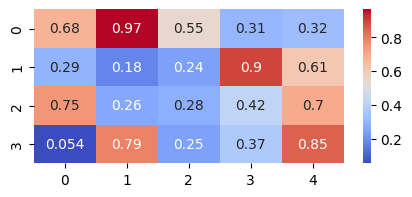

In [145]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 表示の精度を設定
np.set_printoptions(precision=3, suppress=False)
plt.rcParams['figure.figsize'] = (5, 2)

N, M = 4, 5
A = np.random.rand(N, M)
sns.heatmap(A, annot=True, cmap='coolwarm')

$A^TA$ は対称行列

<Axes: >

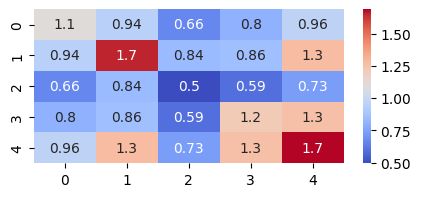

In [146]:
ATA = A.T @ A
sns.heatmap(ATA, annot=True, cmap='coolwarm')

固有値はすべて実数で非負（数値誤差に注意）

w_right=array([4.980e+00, 6.364e-01, 4.016e-01, 1.339e-01, 4.945e-17])


<Axes: >

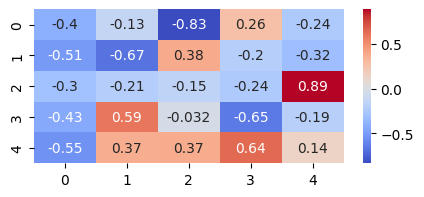

In [147]:
import numpy.linalg as la

w_right, V = la.eigh(ATA)
# 固有値が大きい順
w_right, V = w_right[::-1], V[:, ::-1]
print(f"{w_right=}")
sns.heatmap(V, annot=True, cmap='coolwarm')

固有ベクトルは$V$の各列が対応。
検算で $\vec{v}^T(A^TA)\vec{v}-w$ を計算。

<Axes: >

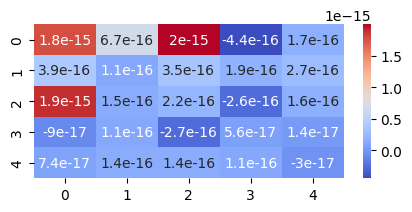

In [148]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

$V$ 行列は直交行列(ユニタリー行列)で[右特異ベクトル](https://manabitimes.jp/math/1280#5)

<Axes: >

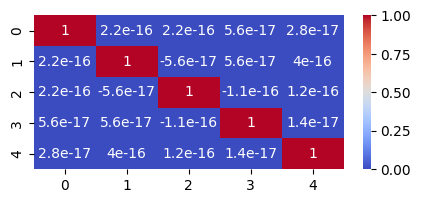

In [149]:
import seaborn as sns

# 検算。ユニタリなら単位行列に近くなる。
sns.heatmap(V.T @ V, annot=True, cmap='coolwarm')

### 左特異ベクトル

同様に $AA^T$ について計算し左特異ベクトル$U$を求める

w_left=array([4.98 , 0.636, 0.402, 0.134])


<Axes: >

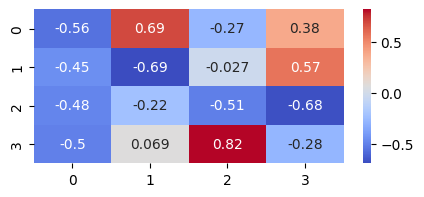

In [150]:
AAT = A @ A.T
w_left, U = la.eigh(AAT)
# 固有値が大きい順
w_left, U = w_left[::-1], U[:, ::-1]

print(f"{w_left=}")
sns.heatmap(U, annot=True, cmap='coolwarm')

左特異ベクトルを検算

<Axes: >

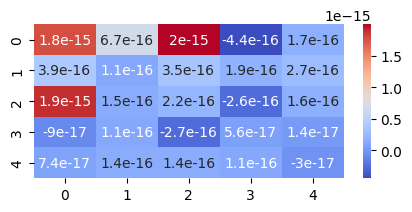

In [151]:
residuals = V.T @ ATA @ V - np.diag(w_right)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

<Axes: >

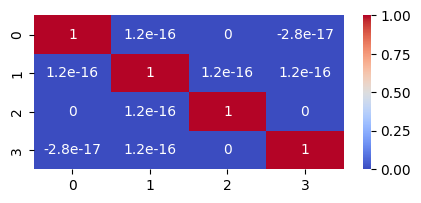

In [152]:
sns.heatmap(U.T @ U, annot=True, cmap='coolwarm')

### 特異値分解

数値誤差の対策。ほぼ0は0とする。

In [153]:
w_right = np.array([w if abs(w) > 1e-10 else 0 for w in w_right])
w_left = np.array([w if abs(w) > 1e-10 else 0 for w in w_left])
print(f"{w_right=}")
print(f"{w_left=}")

w_right=array([4.98 , 0.636, 0.402, 0.134, 0.   ])
w_left=array([4.98 , 0.636, 0.402, 0.134])


$A^TA, AA^T$ の固有値の平方根は特異値

In [154]:
sigma_right = np.sqrt(w_right)
sigma_left = np.sqrt(w_left)
print(f"{sigma_right=}")
print(f"{sigma_left=}")

sigma_right=array([2.232, 0.798, 0.634, 0.366, 0.   ])
sigma_left=array([2.232, 0.798, 0.634, 0.366])


特異値による行列 $\Sigma$ を作成

In [155]:
Sigma = np.zeros_like(A)
sigma = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma[:len(sigma), :len(sigma)] = np.diag(sigma)
print(f"{Sigma=}")

Sigma=array([[2.232, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.798, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.634, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.366, 0.   ]])


固有ベクトルには符号の不定性があるためそのままでは$A=U\Sigma V^T$を満たすとは限らない。

$\Sigma$の成分は非負なので$(AV)_i=\lambda_iU_i, \lambda_i\geq0$。
そこでこの[条件を満たすように符号の反転をする](
https://math.stackexchange.com/questions/4844816/discrepancies-in-custom-svd-implementation-compared-to-np-linalg-svd-sign-issu)。

<Axes: >

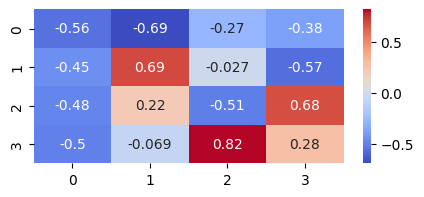

In [156]:
U = np.array([np.sign(np.dot(A @ V[:, idx], U[:, idx])) * U[:, idx]
    for idx in range(U.shape[1])]).T
sns.heatmap(U, annot=True, cmap='coolwarm')

[特異値分解](https://manabitimes.jp/math/1280#5) $A=U\Sigma V^T$ の検算。

<Axes: >

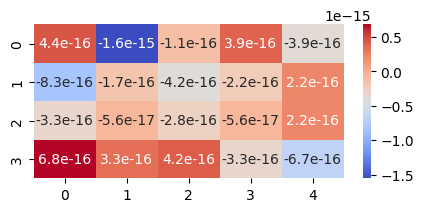

In [157]:
residuals = A - (U @ Sigma @ V.T)
sns.heatmap(residuals, annot=True, cmap='coolwarm')

numpy の標準機能でも特異値分解。

In [158]:
U2, sigma2, V2h = la.svd(A)
print(sigma2)

[2.232 0.798 0.634 0.366]


特異ベクトルは符号の不定性があるため、対角化から求めた結果と一致するとは限らない。

sigma2-sigma=array([-4.441e-16, -5.551e-16, -1.110e-16, -5.551e-17])


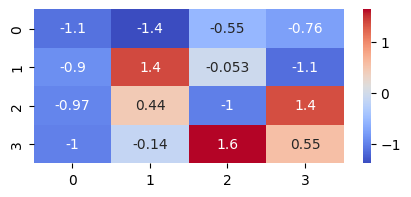

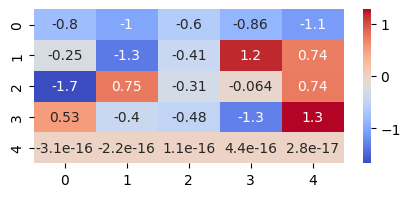

In [159]:
import matplotlib.pyplot as plt

print(f"{sigma2-sigma=}")
sns.heatmap(U-U2, annot=True, cmap='coolwarm')
plt.show()
sns.heatmap(V.T - V2h, annot=True, cmap='coolwarm')
plt.show()

特異分解$A=U\Sigma V^T$はきちんと満たす。

<Axes: >

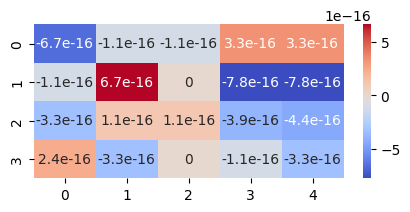

In [160]:
Sigma2 = np.zeros_like(A)
sigma2 = sigma_right if len(sigma_right) < len(sigma_left) else sigma_left
Sigma2[:len(sigma2), :len(sigma2)] = np.diag(sigma2)
residuals = A - (U2 @ Sigma2 @ V2h)
sns.heatmap(residuals, annot=True, cmap='coolwarm')